In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import naive_bayes
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import warnings

# ignore all warnings
warnings.filterwarnings('ignore')

# code that generates warnings here


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [3]:
from google.colab import files
uploaded = files.upload()

Saving Reviews.csv to Reviews.csv


In [6]:
# Load data
data = pd.read_csv('Reviews.csv')

In [7]:
#Check the attributes and their data types
data.dtypes


Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

In [8]:
#Display dataframe dimensions
data.shape

(568454, 10)

In [9]:
#Display only useful columns
data[['Text', 'Score']].head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [10]:
# Select only the 'Text' and 'Score' columns from the original DataFrame
new_data = data[['Text', 'Score']]


# Drop any rows that have duplicate values in the 'Text' column, keeping only the first occurrence
new_data = new_data.drop_duplicates(subset=['Text'], keep='first').reset_index(drop=True)

In [11]:
import re

#Create a function to perfrom data pre-processing
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Join the cleaned words
    text = ' '.join(words)

    return text


In [12]:
#Apply clean text function on text column
new_data['text_clean'] = new_data['Text'].apply(clean_text)

In [13]:
#Drop the original 'Text' column
new_data = new_data.drop(['Text'], axis=1)

In [14]:
#Reorder the columns
new_data = new_data[['text_clean', 'Score']]

In [15]:
#Create a new 'Sentiment' column based on the 'Score' column
new_data['Sentiment'] = new_data['Score'].apply(lambda x: 'positive' if x > 3 else 'negative')

In [16]:
#Drop the original 'Score' column
new_data = new_data.drop(['Score'], axis=1)

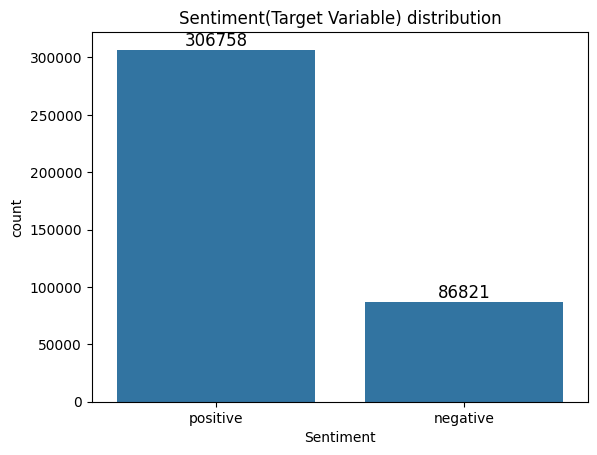

In [17]:
#Visualize the distribution of the 'Sentiment' column using a countplot
ax = sns.countplot(data=new_data, x='Sentiment')
for i, p in enumerate(ax.patches):
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), f'{p.get_height():.0f}',
            ha='center', va='bottom', fontsize=12)
plt.title('Sentiment(Target Variable) distribution')
plt.show()

In [18]:
#Initialize the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()


#Define a function to get the sentiment score for each text
def get_sentiment_score(text):
    return sid.polarity_scores(text)['compound']

In [19]:
#Apply the 'get_sentiment_score' function to the 'text_clean' column and create a new 'Sentiment_score' column
new_data['Sentiment_score'] = new_data['text_clean'].apply(get_sentiment_score)

In [20]:
new_data.head()

,text_clean,Sentiment,Sentiment_score
0,bought several vitality canned dog food produc...,positive,0.9413
1,product arrived labeled jumbo salted peanutsth...,negative,-0.1027
2,confection around century light pillowy citrus...,positive,0.8624
3,looking secret ingredient robitussin believe f...,negative,0.4404
4,great taffy great price wide assortment yummy ...,positive,0.9468


In [21]:
#Define a function to convert the sentiment score into a sentiment category
def get_sentiment_category(score):
    if score > 0.5:
        return 'positive'
    else:
        return 'negative'


In [22]:
#Apply the 'get_sentiment_category' function to the 'Sentiment_score' column and create a new 'Sentiment_category' column
new_data['Sentiment_category'] = new_data['Sentiment_score'].apply(get_sentiment_category)

In [23]:
new_data.head()

,text_clean,Sentiment,Sentiment_score,Sentiment_category
0,bought several vitality canned dog food produc...,positive,0.9413,positive
1,product arrived labeled jumbo salted peanutsth...,negative,-0.1027,negative
2,confection around century light pillowy citrus...,positive,0.8624,positive
3,looking secret ingredient robitussin believe f...,negative,0.4404,negative
4,great taffy great price wide assortment yummy ...,positive,0.9468,positive


In [24]:
# Compare the two columns element-wise
differences = new_data['Sentiment'] != new_data['Sentiment_category']

# Count the number of differences
num_differences = differences.sum()

In [25]:
# Select rows where 'Sentiment' does not match 'Sentiment_category', and show the selected columns
new_data.loc[new_data['Sentiment'] != new_data['Sentiment_category'],['Sentiment','Sentiment_category','Sentiment_score','text_clean']]

,Sentiment,Sentiment_category,Sentiment_score,text_clean
11,positive,negative,-0.6486,one boy needed lose weight didnt put food floo...
16,negative,positive,0.9313,love eating good watching tv looking movie swe...
23,positive,negative,0.4767,love candy weight watcher cut back still craving
24,positive,negative,0.3182,lived u yr miss twizzlers go back visit someon...
25,positive,negative,0.0000,product received advertisedbr br hrefhttpwwwam...
...,...,...,...,...
393564,positive,negative,0.4019,need recipe wife interested trying however web...
393570,positive,negative,0.3182,make mix star anise often difficult find usual...
393571,negative,positive,0.5423,ordered month back great latest batch terrible...
393573,positive,negative,-0.0675,complaint there much dont use huge amount spic...


In [26]:
# Calculate accuracy
accuracy = accuracy_score(new_data['Sentiment'],new_data['Sentiment_category'])

print("Accuracy:", accuracy)

Accuracy: 0.7830092560832768


Model Preparation

In [27]:
#Split the data into training and testing sets
X = new_data['text_clean']
y = new_data['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [28]:
#Check the shapes of the resulting arrays
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((275505,), (118074,), (275505,), (118074,))

In [29]:
#Apply the TfidfVectorizer to convert the text into numerical vectors
vectorizer = TfidfVectorizer(binary=True)
X_train_tr = vectorizer.fit_transform(X_train)
X_test_tr = vectorizer.transform(X_test)

# Model Training and Evaluation

#### Logistic Regression

In [30]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_tr, y_train)
lr_train_acc = lr.score(X_train_tr, y_train)
lr_test_acc = lr.score(X_test_tr, y_test)
lr_pred = lr.predict(X_test_tr)
lr_report = classification_report(y_test, lr_pred,output_dict=True)
lrv_report = classification_report(y_test, lr_pred)
# Print the results
print(f'Train Accuracy:', lr_train_acc)
print(f'Test Accuracy:', lr_test_acc)
print(f'Classification Report:\n', lrv_report)

Train Accuracy: 0.9013919892560933
Test Accuracy: 0.8880701932686281
Classification Report:
               precision    recall  f1-score   support

    negative       0.81      0.65      0.72     26046
    positive       0.91      0.96      0.93     92028

    accuracy                           0.89    118074
   macro avg       0.86      0.80      0.82    118074
weighted avg       0.88      0.89      0.88    118074



#### Bernoulli Naive Bayes

In [31]:
bNB = naive_bayes.BernoulliNB()
bNB.fit(X_train_tr, y_train)
bNB_train_acc = bNB.score(X_train_tr, y_train)
bNB_test_acc = bNB.score(X_test_tr, y_test)
bNB_pred = bNB.predict(X_test_tr)
bNB_report = classification_report(y_test, bNB_pred,output_dict=True)
bNBv_report = classification_report(y_test, bNB_pred)
print(f'Train Accuracy:', bNB_train_acc)
print(f'Test Accuracy:', bNB_test_acc)
print(f'Classification Report:\n', bNBv_report)

Train Accuracy: 0.839585488466634
Test Accuracy: 0.8246608059352609
Classification Report:
               precision    recall  f1-score   support

    negative       0.63      0.49      0.55     26046
    positive       0.86      0.92      0.89     92028

    accuracy                           0.82    118074
   macro avg       0.75      0.70      0.72    118074
weighted avg       0.81      0.82      0.82    118074



#### Multinomial Naive Bayes

In [32]:
mNB = naive_bayes.MultinomialNB()
mNB.fit(X_train_tr, y_train)
mNB_train_acc = mNB.score(X_train_tr, y_train)
mNB_test_acc = mNB.score(X_test_tr, y_test)
mNB_pred = mNB.predict(X_test_tr)
mNB_report = classification_report(y_test, mNB_pred,output_dict=True)
mNBv_report = classification_report(y_test, mNB_pred)
print(f'Train Accuracy:', mNB_train_acc)
print(f'Test Accuracy:', mNB_test_acc)
print(f'Classification Report:\n', mNBv_report)

Train Accuracy: 0.8037095515507886
Test Accuracy: 0.7935193183935498
Classification Report:
               precision    recall  f1-score   support

    negative       0.95      0.07      0.13     26046
    positive       0.79      1.00      0.88     92028

    accuracy                           0.79    118074
   macro avg       0.87      0.53      0.50    118074
weighted avg       0.83      0.79      0.72    118074



#### Decision Tree

In [33]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_split=5, min_samples_leaf=2)
dt.fit(X_train_tr, y_train)
dt_train_acc = dt.score(X_train_tr, y_train)
dt_test_acc = dt.score(X_test_tr, y_test)
dt_test_pred = dt.predict(X_test_tr)
dt_report = classification_report(y_test, dt_test_pred,output_dict=True)
dtv_report = classification_report(y_test, dt_test_pred)
print(f'Train Accuracy:', dt_train_acc)
print(f'Test Accuracy:', dt_test_acc)
print(f'Classification Report:\n', dtv_report)

Train Accuracy: 0.8084862343696122
Test Accuracy: 0.8022595999119196
Classification Report:
               precision    recall  f1-score   support

    negative       0.65      0.23      0.34     26046
    positive       0.82      0.97      0.88     92028

    accuracy                           0.80    118074
   macro avg       0.73      0.60      0.61    118074
weighted avg       0.78      0.80      0.76    118074



#### Random Forest

In [34]:
#These are the best parameters got using GridsearchCV, so avoiding grid again
rf = RandomForestClassifier(max_depth = 20, min_samples_split = 5, n_estimators = 50)
rf.fit(X_train_tr, y_train)
rf_train_acc = rf.score(X_train_tr, y_train)
rf_test_acc = rf.score(X_test_tr, y_test)
rf_test_pred = rf.predict(X_test_tr)
rf_report = classification_report(y_test, rf_test_pred,output_dict=True)
rfv_report = classification_report(y_test, rf_test_pred)
print(f'Train Accuracy:', rf_train_acc)
print(f'Test Accuracy:', rf_test_acc)
print(f'Classification Report:\n', rfv_report)

Train Accuracy: 0.7794305003538956
Test Accuracy: 0.779417992106645
Classification Report:
               precision    recall  f1-score   support

    negative       1.00      0.00      0.00     26046
    positive       0.78      1.00      0.88     92028

    accuracy                           0.78    118074
   macro avg       0.89      0.50      0.44    118074
weighted avg       0.83      0.78      0.68    118074



In [35]:
import pandas as pd

# Create a dictionary to store the results
results_dict = {
    'Model': ['LogisticRegression','Bernoulli Naive Bayes', 'Multinomial Naive Bayes', 'Decision Tree', 'Random Forest'],
    'Train Accuracy': [lr_train_acc,bNB_train_acc, mNB_train_acc, dt_train_acc, rf_train_acc],
    'Test Accuracy': [lr_test_acc,bNB_test_acc, mNB_test_acc, dt_test_acc, rf_test_acc],
    'Precision': [lr_report['macro avg']['precision'],bNB_report['macro avg']['precision'] , mNB_report['macro avg']['precision']
                  , dt_report['macro avg']['precision'] , rf_report['macro avg']['precision'] ],
    'recall': [lr_report['macro avg']['recall'],bNB_report['macro avg']['recall'] , mNB_report['macro avg']['recall']
                  , dt_report['macro avg']['recall'] , rf_report['macro avg']['recall'] ],
    'f1-score': [lr_report['macro avg']['f1-score'],bNB_report['macro avg']['f1-score'] , mNB_report['macro avg']['f1-score']
                  , dt_report['macro avg']['f1-score'] , rf_report['macro avg']['f1-score'] ]
}

# Convert the dictionary to a data frame
results_df = pd.DataFrame.from_dict(results_dict)

# Display the data frame
results_df


,Model,Train Accuracy,Test Accuracy,Precision,recall,f1-score
0,LogisticRegression,0.901392,0.888070,0.856166,0.801914,0.824351
1,Bernoulli Naive Bayes,0.839585,0.824661,0.748387,0.704447,0.721413
2,Multinomial Naive Bayes,0.803710,0.793519,0.872346,0.533152,0.504269
3,Decision Tree,0.808486,0.802260,0.731561,0.595974,0.609929
4,Random Forest,0.779431,0.779418,0.889708,0.500019,0.438056


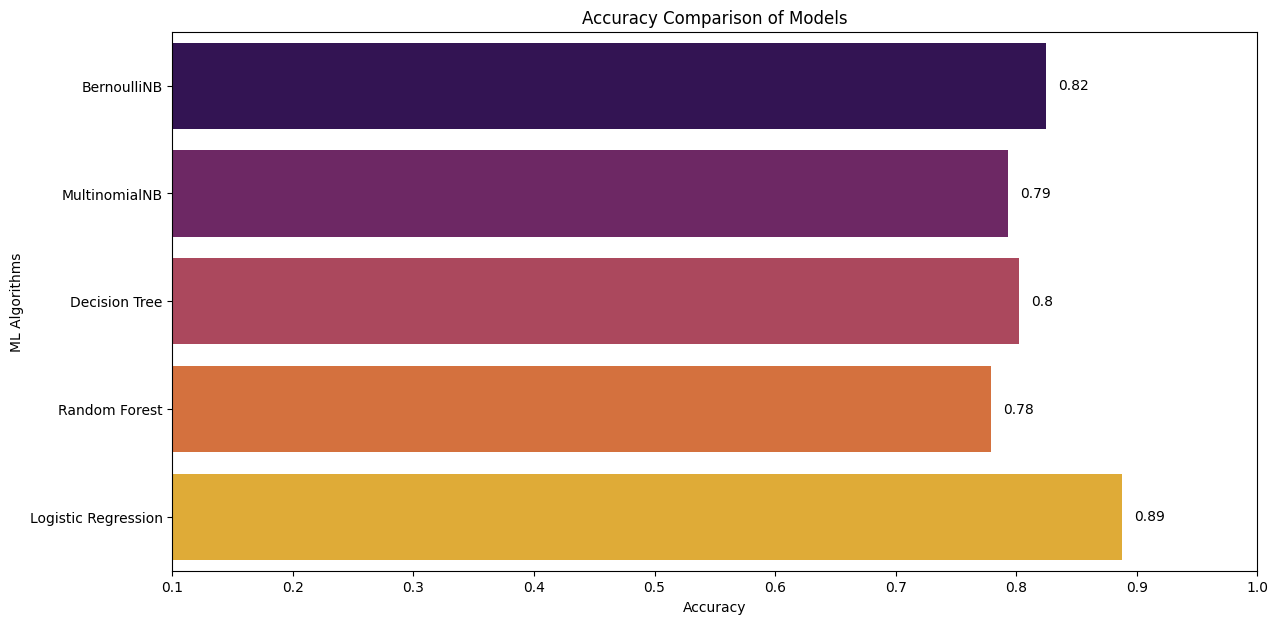

In [36]:
acc = [bNB_test_acc, mNB_test_acc, dt_test_acc, rf_test_acc, lr_test_acc]
model = ['BernoulliNB','MultinomialNB', 'Decision Tree', 'Random Forest', 'Logistic Regression']
plt.figure(figsize=[14,7],dpi = 100, facecolor='white');
plt.title('Accuracy Comparison of Models');
plt.xlabel('Accuracy');
plt.ylabel('ML Algorithms');
ax=sns.barplot(x = acc,y = model,palette='inferno');
ax.set_xlim(0.1, 1.0)
for i, v in enumerate(acc):
    ax.text(v+0.01, i, str(round(v, 2)), va='center')
plt.show()